In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [2]:
cabs = pd.read_csv("cab_rides.csv")
weather = pd.read_csv("weather.csv")

## Data Cleaning and Manipulation

In [3]:
weather.isna().sum()

temp             0
location         0
clouds           0
pressure         0
rain          5382
time_stamp       0
humidity         0
wind             0
dtype: int64

In [4]:
cabs.shape

(693071, 10)

In [5]:
weather.shape

(6276, 8)

In [6]:
cabs.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [7]:
weather.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49


# -----------------------------------------------------------------------------------------

In [8]:
# Filling the Null values in the column "Rain" with 0's as it didn't rain at that time

weather['rain'] = weather['rain'].fillna(0)

In [9]:
# Converting Unix Epoch Timestamps to DateTime

cabs['time_stamp'] = pd.to_datetime(cabs['time_stamp'], unit='ms')
weather['time_stamp'] = pd.to_datetime(weather['time_stamp'], unit='s')

In [10]:
# Formatting timestamp in both DataFrames to 'YYYY-MM-DD HH'

cabs['time_stamp'] = cabs['time_stamp'].dt.strftime('%Y-%m-%d %H')
weather['time_stamp'] = weather['time_stamp'].dt.strftime('%Y-%m-%d %H')

In [11]:
# Merging the two dataframes together

data = pd.merge(cabs, weather, left_on=['source', 'time_stamp'], right_on=['location', 'time_stamp'], how='left')

In [12]:
# Dropping the column "Location"

data = data.drop('location', axis=1)

In [13]:
data

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,temp,clouds,pressure,rain,humidity,wind
0,0.44,Lyft,2018-12-16 09,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,38.46,0.29,1022.25,0.0000,0.76,7.68
1,0.44,Lyft,2018-11-27 02,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,44.31,1.00,1003.17,0.1123,0.90,13.69
2,0.44,Lyft,2018-11-27 02,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,43.82,0.99,1002.59,0.0997,0.89,11.57
3,0.44,Lyft,2018-11-28 01,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,NaN,NaN,NaN,NaN,NaN,NaN
4,0.44,Lyft,2018-11-30 04,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,35.08,0.00,1013.71,0.0000,0.70,5.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268634,1.00,Uber,2018-12-01 23,North End,West End,13.0,1.0,616d3611-1820-450a-9845-a9ff304a4842,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,36.69,0.41,1023.64,0.0000,0.76,2.51
1268635,1.00,Uber,2018-12-01 23,North End,West End,9.5,1.0,633a3fc3-1f86-4b9e-9d48-2b7132112341,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,36.69,0.41,1023.64,0.0000,0.76,2.51
1268636,1.00,Uber,2018-12-01 23,North End,West End,NaN,1.0,64d451d0-639f-47a4-9b7c-6fd92fbd264f,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,36.69,0.41,1023.64,0.0000,0.76,2.51
1268637,1.00,Uber,2018-12-01 23,North End,West End,27.0,1.0,727e5f07-a96b-4ad1-a2c7-9abc3ad55b4e,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,36.69,0.41,1023.64,0.0000,0.76,2.51


### Handling Missing Values

In [14]:
data.isna().sum()

distance                 0
cab_type                 0
time_stamp               0
destination              0
source                   0
price               100909
surge_multiplier         0
id                       0
product_id               0
name                     0
temp                  2964
clouds                2964
pressure              2964
rain                  2964
humidity              2964
wind                  2964
dtype: int64

In [15]:
# Dropping all Na's in the data

data = data.dropna()

### Handling Duplicates

In [16]:
data.duplicated().sum()

11854

In [17]:
data = data.drop_duplicates()

In [18]:
# Dropping orders with the same order_id

data = data.drop_duplicates(subset=['id'])

In [19]:
data

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,temp,clouds,pressure,rain,humidity,wind
0,0.44,Lyft,2018-12-16 09,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,38.46,0.29,1022.25,0.0000,0.76,7.68
1,0.44,Lyft,2018-11-27 02,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,44.31,1.00,1003.17,0.1123,0.90,13.69
4,0.44,Lyft,2018-11-30 04,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,35.08,0.00,1013.71,0.0000,0.70,5.25
5,0.44,Lyft,2018-11-29 03,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,37.58,0.42,998.64,0.0000,0.71,11.30
8,0.44,Lyft,2018-12-17 18,North Station,Haymarket Square,16.5,1.0,f6f6d7e4-3e18-4922-a5f5-181cdd3fa6f2,lyft_lux,Lux Black,40.78,0.93,1000.15,0.0000,0.79,7.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268633,1.00,Uber,2018-12-01 23,North End,West End,9.5,1.0,353e6566-b272-479e-a9c6-98bd6cb23f25,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,36.69,0.41,1023.64,0.0000,0.76,2.51
1268634,1.00,Uber,2018-12-01 23,North End,West End,13.0,1.0,616d3611-1820-450a-9845-a9ff304a4842,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,36.69,0.41,1023.64,0.0000,0.76,2.51
1268635,1.00,Uber,2018-12-01 23,North End,West End,9.5,1.0,633a3fc3-1f86-4b9e-9d48-2b7132112341,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,36.69,0.41,1023.64,0.0000,0.76,2.51
1268637,1.00,Uber,2018-12-01 23,North End,West End,27.0,1.0,727e5f07-a96b-4ad1-a2c7-9abc3ad55b4e,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,36.69,0.41,1023.64,0.0000,0.76,2.51


### Renaming Columns

In [20]:
# Renaming the necessary columns

data = data.rename(columns={'cab_type': 'cab_company'})
data = data.rename(columns={'time_stamp': 'order_date'})
data = data.rename(columns={'source': 'origin'})
data = data.rename(columns={'id': 'order_id'})
data = data.rename(columns={'name': 'car_type'})

In [21]:
data

,distance,cab_company,order_date,destination,origin,price,surge_multiplier,order_id,product_id,car_type,temp,clouds,pressure,rain,humidity,wind
0,0.44,Lyft,2018-12-16 09,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,38.46,0.29,1022.25,0.0000,0.76,7.68
1,0.44,Lyft,2018-11-27 02,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,44.31,1.00,1003.17,0.1123,0.90,13.69
4,0.44,Lyft,2018-11-30 04,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,35.08,0.00,1013.71,0.0000,0.70,5.25
5,0.44,Lyft,2018-11-29 03,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,37.58,0.42,998.64,0.0000,0.71,11.30
8,0.44,Lyft,2018-12-17 18,North Station,Haymarket Square,16.5,1.0,f6f6d7e4-3e18-4922-a5f5-181cdd3fa6f2,lyft_lux,Lux Black,40.78,0.93,1000.15,0.0000,0.79,7.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268633,1.00,Uber,2018-12-01 23,North End,West End,9.5,1.0,353e6566-b272-479e-a9c6-98bd6cb23f25,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,36.69,0.41,1023.64,0.0000,0.76,2.51
1268634,1.00,Uber,2018-12-01 23,North End,West End,13.0,1.0,616d3611-1820-450a-9845-a9ff304a4842,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,36.69,0.41,1023.64,0.0000,0.76,2.51
1268635,1.00,Uber,2018-12-01 23,North End,West End,9.5,1.0,633a3fc3-1f86-4b9e-9d48-2b7132112341,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,36.69,0.41,1023.64,0.0000,0.76,2.51
1268637,1.00,Uber,2018-12-01 23,North End,West End,27.0,1.0,727e5f07-a96b-4ad1-a2c7-9abc3ad55b4e,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,36.69,0.41,1023.64,0.0000,0.76,2.51


### Renaming Values

In [22]:
data['car_type'] = data['car_type'].replace({
    'Shared': 'Lyft Shared',
    'UberPool': 'UberPool',
    'Lux': 'Lyft Lux',
    'Lux Black': 'Lyft Lux',
    'Black': 'Uber Lux',
    'Lux Black XL': 'Lyft Lux XL',
    'Black SUV': 'Uber Lux XL',
    'UberXL': 'Uber XL',
    'Lyft XL': 'Lyft XL',
    'Lyft': 'Lyft',
    'UberX': 'UberX',
    'WAV': 'Uber WAV'
})

### Adding Category

In [23]:
data = data.drop('product_id', axis=1)

def categorize_car(car_type):
    if car_type in ['Lyft Shared', 'UberPool']:
        return 'Shared'
    elif car_type in ['Lyft Lux', 'Uber Lux']:
        return 'Lux'
    elif car_type in ['Lyft Lux XL', 'Uber Lux XL']:
        return 'Lux XL'
    elif car_type in ['Uber XL', 'Lyft XL']:
        return 'XL'
    elif car_type in ['Lyft', 'UberX']:
        return 'Standard'
    elif car_type == 'Uber WAV':
        return 'Wheelchair'
    else:
        return 'Unknown'

data['car_category'] = data['car_type'].apply(categorize_car)

### Extracting Day_of_week and Hour from Date

In [24]:
data['order_date'] = pd.to_datetime(data['order_date'])
data['hour'] = data['order_date'].dt.hour
data['day_of_week'] = data['order_date'].dt.day_name()

## Descriptive Analysis

In [25]:
data.describe()

,distance,price,surge_multiplier,temp,clouds,pressure,rain,humidity,wind,hour
count,635242.000000,635242.000000,635242.000000,635242.000000,635242.000000,635242.000000,635242.000000,635242.000000,635242.000000,635242.000000
mean,2.188876,16.544083,1.015064,39.222256,0.667847,1010.228290,0.005623,0.747293,6.917946,11.636449
std,1.135326,9.323372,0.095413,6.599625,0.313867,13.383809,0.026626,0.128965,3.648678,6.945765
min,0.020000,2.500000,1.000000,19.620000,0.000000,988.250000,0.000000,0.450000,0.300000,0.000000
25%,1.270000,9.000000,1.000000,36.110000,0.430000,999.950000,0.000000,0.650000,3.630000,6.000000
50%,2.160000,13.500000,1.000000,40.180000,0.760000,1009.550000,0.000000,0.730000,6.740000,12.000000
75%,2.930000,22.500000,1.000000,43.600000,0.960000,1021.877500,0.000000,0.870000,9.880000,18.000000
max,7.860000,97.500000,3.000000,55.410000,1.000000,1035.120000,0.274000,0.990000,18.180000,23.000000


In [26]:
correlation_matrix = data.corr()

In [27]:
correlation_matrix

,distance,price,surge_multiplier,temp,clouds,pressure,rain,humidity,wind,hour
distance,1.000000,0.345082,0.025830,-0.003099,0.000342,0.003708,0.000789,-0.003740,-0.004251,0.002332
price,0.345082,1.000000,0.240325,0.000005,0.001290,0.001012,0.000710,-0.001704,-0.001185,0.000706
surge_multiplier,0.025830,0.240325,1.000000,-0.001635,-0.001996,-0.002912,-0.001067,-0.001253,0.001286,0.000108
temp,-0.003099,0.000005,-0.001635,1.000000,0.437995,-0.377918,0.133400,0.366563,0.120664,0.220141
clouds,0.000342,0.001290,-0.001996,0.437995,1.000000,-0.210674,0.210941,0.509777,0.125876,0.071818
pressure,0.003708,0.001012,-0.002912,-0.377918,-0.210674,1.000000,-0.069215,-0.132083,-0.569770,-0.073378
rain,0.000789,0.000710,-0.001067,0.133400,0.210941,-0.069215,1.000000,0.209892,0.218114,-0.104754
humidity,-0.003740,-0.001704,-0.001253,0.366563,0.509777,-0.132083,0.209892,1.000000,-0.208435,-0.244122
wind,-0.004251,-0.001185,0.001286,0.120664,0.125876,-0.569770,0.218114,-0.208435,1.000000,0.027345
hour,0.002332,0.000706,0.000108,0.220141,0.071818,-0.073378,-0.104754,-0.244122,0.027345,1.000000


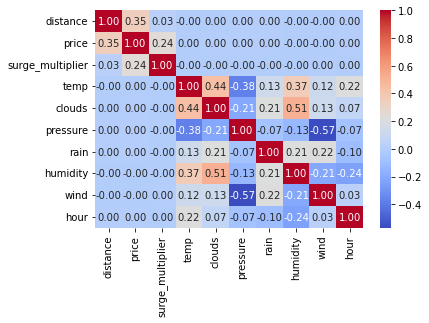

In [28]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [29]:
# data.to_csv('cleaned_cabs.csv', index=False)

## Models

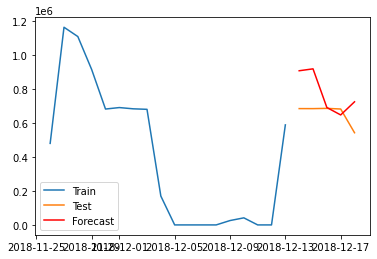

In [30]:
df = data.copy()

df['order_date'] = pd.to_datetime(df['order_date'])
df = df.set_index('order_date')

# Resample the data to daily frequency, summing the values for the day
df_resampled = df.resample('D').sum()

ts = df_resampled['price']

# Check for missing dates and fill if needed
ts = ts.asfreq('D', fill_value=0)

# Train-test split
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

# Fit ARIMA model
model = ARIMA(train, order=(5, 1, 0))  # Adjust the order according to your data
fit_model = model.fit()

# Forecast
forecast = fit_model.forecast(steps=len(test))

plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.show()

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Assuming 'test' contains the actual values and 'forecast' contains the predicted values

mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = mean_squared_error(test, forecast, squared=False)  # Pass squared=False to get RMSE
mape = mean_absolute_percentage_error(test, forecast)

print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}")


MAE: 135824.88373472018, MSE: 27775449521.43739, RMSE: 166659.68175127837, MAPE: 0.2123635006703851


c:\Users\Gor Mkrtchyan\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


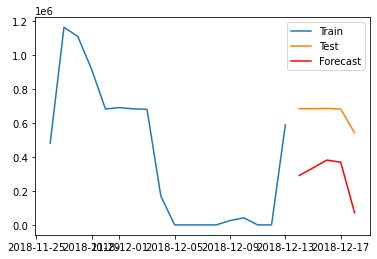

In [32]:
df = data.copy()

df['order_date'] = pd.to_datetime(df['order_date'])
df = df.set_index('order_date')

# Resample the data to daily frequency, summing the values for the day
df_resampled = df.resample('D').sum()

ts = df_resampled['price']

# Check for missing dates and fill if needed
ts = ts.asfreq('D', fill_value=0)

# Train-test split
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

# Fit ETS model
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=7)
fit_model = model.fit()
forecast = fit_model.forecast(steps=len(test))

# Plot results
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Assuming 'test' contains the actual values and 'forecast' contains the predicted values

mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = mean_squared_error(test, forecast, squared=False)  # Pass squared=False to get RMSE
mape = mean_absolute_percentage_error(test, forecast)

print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}")


MAE: 365976.6905995126, MSE: 137647297010.9095, RMSE: 371008.4864405523, MAPE: 0.570680381784992


c:\Users\Gor Mkrtchyan\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


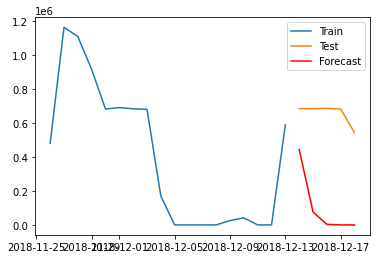

In [34]:
df = data.copy()

df['order_date'] = pd.to_datetime(df['order_date'])
df = df.set_index('order_date')

# Resample the data to daily frequency, summing the values for the day
df_resampled = df.resample('D').sum()

ts = df_resampled['price']

# Check for missing dates and fill if needed
ts = ts.asfreq('D', fill_value=0)

# Train-test split
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

# Gaussian Process Regression
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
model.fit(np.arange(len(train)).reshape(-1, 1), train.values)

# Forecast
forecast, std_dev = model.predict(np.arange(len(train), len(train) + len(test)).reshape(-1, 1), return_std=True)

# Plot results
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.fill_between(test.index, forecast - std_dev, forecast + std_dev, color='gray', alpha=0.2)
plt.legend()
plt.show()

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Assuming 'test' contains the actual values and 'forecast' contains the predicted values

mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = mean_squared_error(test, forecast, squared=False)  # Pass squared=False to get RMSE
mape = mean_absolute_percentage_error(test, forecast)

print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}")


MAE: 551332.672936452, MSE: 330802663114.7099, RMSE: 575154.4689165772, MAPE: 0.8471351803852084


### Ride Recommendation System (Uber or Lyft)

In [36]:
def recommend_ride(data, origin, destination, day_of_week, hour):
    # Filter data based on user inputs
    filtered_data = data[
        (data['origin'] == origin) &
        (data['destination'] == destination) &
        (data['day_of_week'] == day_of_week)
    ]

    # Check if data exists for the specific hour
    if hour in filtered_data['hour'].unique():
        # Group by car category and calculate average price for each car type
        grouped_data = filtered_data.groupby(['car_category', 'car_type'])['price'].mean()

        # Iterate over unique car categories and provide recommendations
        for car_category in data['car_category'].unique():
            print(f"car_category: {car_category}")

            try:
                # Get data for the specified hour
                category_data = grouped_data.loc[car_category]
                if not category_data.empty:
                    for car_type, avg_price in category_data.items():
                        print(f"{car_type}: {avg_price:.2f}")

                    cheapest_option = category_data.idxmin()
                    suggestion = 'No data available' if pd.isnull(cheapest_option) else cheapest_option
                    print(f"We suggest using {suggestion}\n")
                else:
                    print("No data available for this car category in this hour\n")
            except KeyError:
                print("No data available for this car category\n")
    else:
        # No data for the specific hour, calculate mean of the day
        daily_filtered_data = filtered_data[filtered_data['hour'] != hour]
        daily_grouped_data = daily_filtered_data.groupby(['car_category', 'car_type'])['price'].mean()

        for car_category in data['car_category'].unique():
            print(f"car_category: {car_category}")

            try:
                category_data = daily_grouped_data.loc[car_category]
                for car_type, avg_price in category_data.items():
                    print(f"{car_type}: {avg_price:.2f} (estimated average for the day)")

                cheapest_option = category_data.idxmin()
                suggestion = 'No data available' if pd.isnull(cheapest_option) else cheapest_option
                print(f"We suggest using {suggestion} (based on daily average)\n")
            except KeyError:
                print("No data available for this car category\n")

# User inputs
user_origin = input("Enter your current location from the list: \n \nHaymarket Square, Back Bay, North End, North Station, Beacon Hill, Boston University, Fenway, South Station, Theatre District, West End, Financial District, Northeastern University: ")
user_destination = input("Enter your destination from the list: \n \nHaymarket Square, Back Bay, North End, North Station, Beacon Hill, Boston University, Fenway, South Station, Theatre District, West End, Financial District, Northeastern University: ")
user_day_of_week = input("Enter the day of the week: ")
user_hour = int(input("Enter the hour of the day (0-23): "))

# Provide recommendations
recommend_ride(data, user_origin, user_destination, user_day_of_week, user_hour)

car_category: Shared
Lyft Shared: 4.59
UberPool: 7.91
We suggest using Lyft Shared

car_category: Lux
Lyft Lux: 15.91
Uber Lux: 16.71
We suggest using Lyft Lux

car_category: Lux XL
Lyft Lux XL: 26.83
Uber Lux XL: 27.24
We suggest using Lyft Lux XL

car_category: XL
Lyft XL: 12.19
Uber XL: 12.87
We suggest using Lyft XL

car_category: Standard
Lyft: 7.78
UberX: 8.54
We suggest using Lyft

car_category: Wheelchair
Uber WAV: 8.45
We suggest using Uber WAV

